In [45]:
import pickle
import pandas as pd
import torch
import io

from explore import LayerwiseQuantizationProblem, QuantizationModel

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


with open('exploration_25_50_8bit.pkl', 'rb') as f:
    d = CPU_Unpickler(f).load()

type(d)

pymoo.core.result.Result

In [46]:
from torchvision import models
from pytorch_quantization import nn as quant_nn

m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
layer_names = []

for name, module in m.named_modules():
    if isinstance(module, quant_nn.TensorQuantizer):
        layer_names.append(name)


In [52]:
import numpy as np

pd.set_option('display.max_rows', 10)
pop = d.pop

df_data = np.empty( (0, 111) )
for h in d.history:
    for ind in h.opt:
        l = np.concatenate( (ind.get("F"), ind.get("X")) )
        l = np.expand_dims(l, axis=0)
        df_data = np.concatenate( (df_data, l), axis=0)

print(df_data.shape)
df = pd.DataFrame(df_data, columns=["Acc", "Bits"] + layer_names)

print(len(df))

df['Acc'] = -df['Acc']
df.sort_values('Bits')

(507, 111)
507


,Acc,Bits,conv1._input_quantizer,conv1._weight_quantizer,layer1.0.conv1._input_quantizer,layer1.0.conv1._weight_quantizer,layer1.0.conv2._input_quantizer,layer1.0.conv2._weight_quantizer,layer1.0.conv3._input_quantizer,layer1.0.conv3._weight_quantizer,...,layer4.1.conv3._weight_quantizer,layer4.2.conv1._input_quantizer,layer4.2.conv1._weight_quantizer,layer4.2.conv2._input_quantizer,layer4.2.conv2._weight_quantizer,layer4.2.conv3._input_quantizer,layer4.2.conv3._weight_quantizer,avgpool._input_quantizer,fc._input_quantizer,fc._weight_quantizer
506,0.771756,2254.0,4.0,9.0,12.0,8.0,5.0,8.0,11.0,8.0,...,10.0,12.0,8.0,8.0,7.0,9.0,6.0,10.0,7.0,8.0
504,0.778085,2258.0,4.0,9.0,12.0,8.0,5.0,8.0,11.0,8.0,...,9.0,12.0,8.0,8.0,7.0,10.0,6.0,10.0,7.0,8.0
494,0.778085,2258.0,4.0,9.0,12.0,8.0,5.0,8.0,11.0,8.0,...,9.0,12.0,8.0,8.0,7.0,10.0,6.0,10.0,7.0,8.0
484,0.774525,2264.0,4.0,9.0,12.0,8.0,5.0,8.0,11.0,8.0,...,9.0,12.0,8.0,8.0,7.0,10.0,6.0,10.0,7.0,8.0
475,0.774525,2264.0,4.0,9.0,12.0,8.0,5.0,8.0,11.0,8.0,...,9.0,12.0,8.0,8.0,7.0,10.0,6.0,10.0,7.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.824565,3961.5,16.0,15.0,16.0,13.0,13.0,15.0,15.0,12.0,...,10.0,14.0,10.0,14.0,15.0,16.0,6.0,11.0,15.0,13.0
386,0.824565,3961.5,16.0,15.0,16.0,13.0,13.0,15.0,15.0,12.0,...,10.0,14.0,10.0,14.0,15.0,16.0,6.0,11.0,15.0,13.0
172,0.824565,3961.5,16.0,15.0,16.0,13.0,13.0,15.0,15.0,12.0,...,10.0,14.0,10.0,14.0,15.0,16.0,6.0,11.0,15.0,13.0
104,0.824565,3961.5,16.0,15.0,16.0,13.0,13.0,15.0,15.0,12.0,...,10.0,14.0,10.0,14.0,15.0,16.0,6.0,11.0,15.0,13.0


<AxesSubplot:xlabel='Acc', ylabel='Bits'>

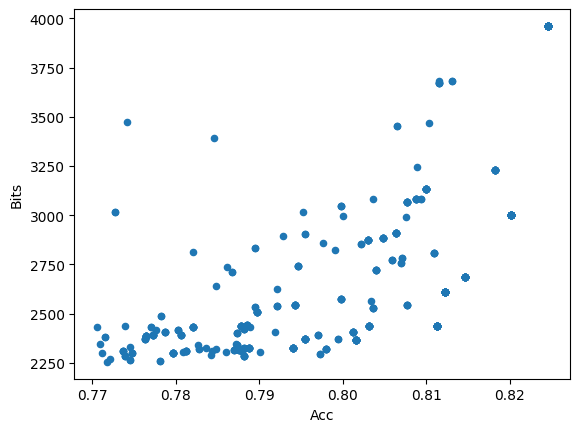

In [48]:
df_sel = df.where(df['Acc'] > 0.75)
df_sel.plot(x='Acc', y='Bits', kind='scatter')

<AxesSubplot:>

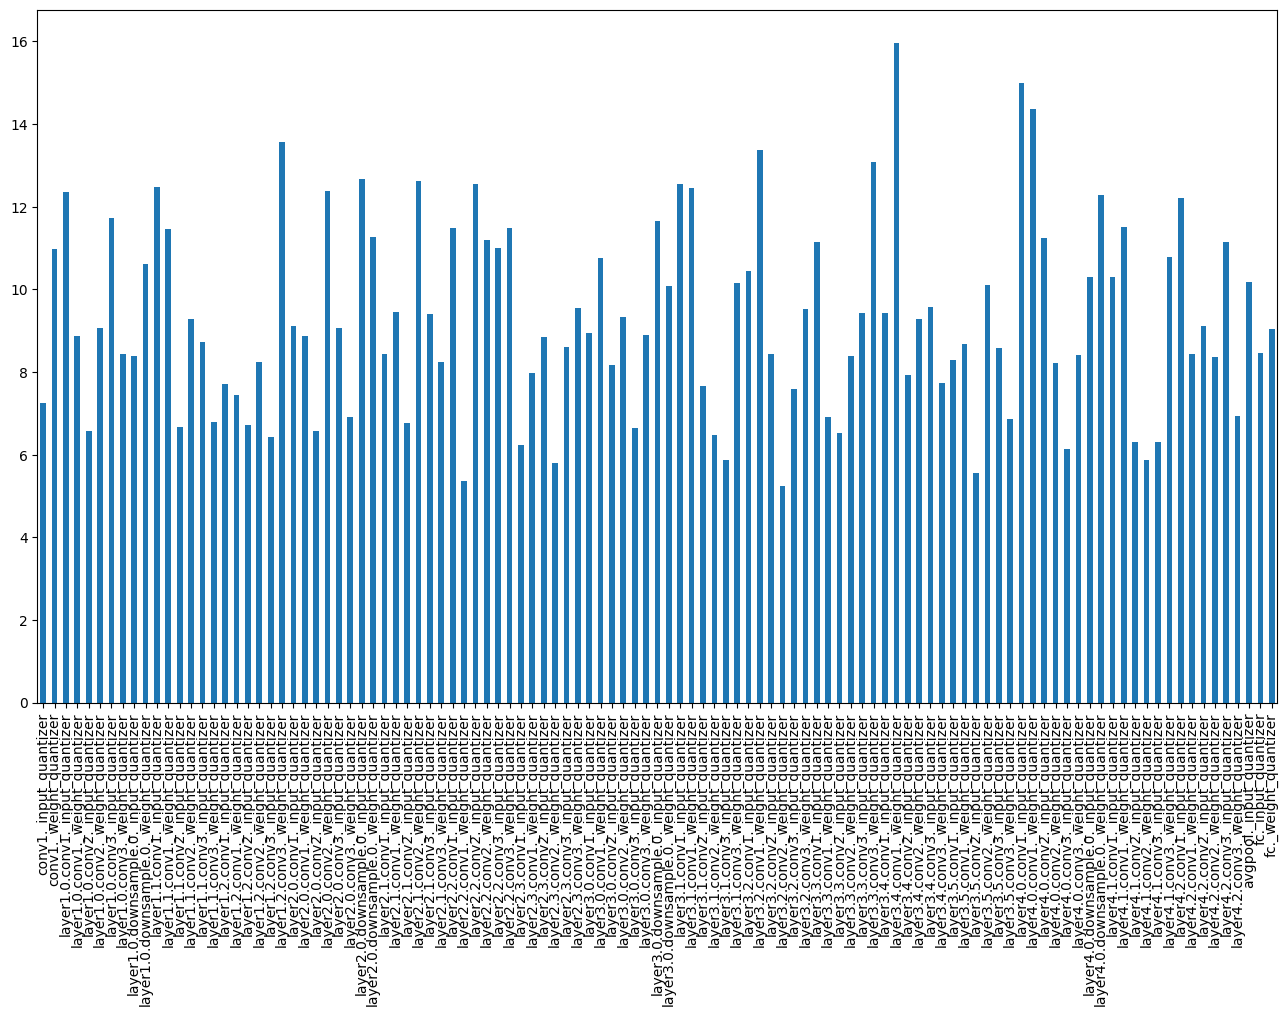

In [49]:
df_means = df_sel.mean().iloc[2:]
df_means.plot(kind='bar', figsize=(16,9))

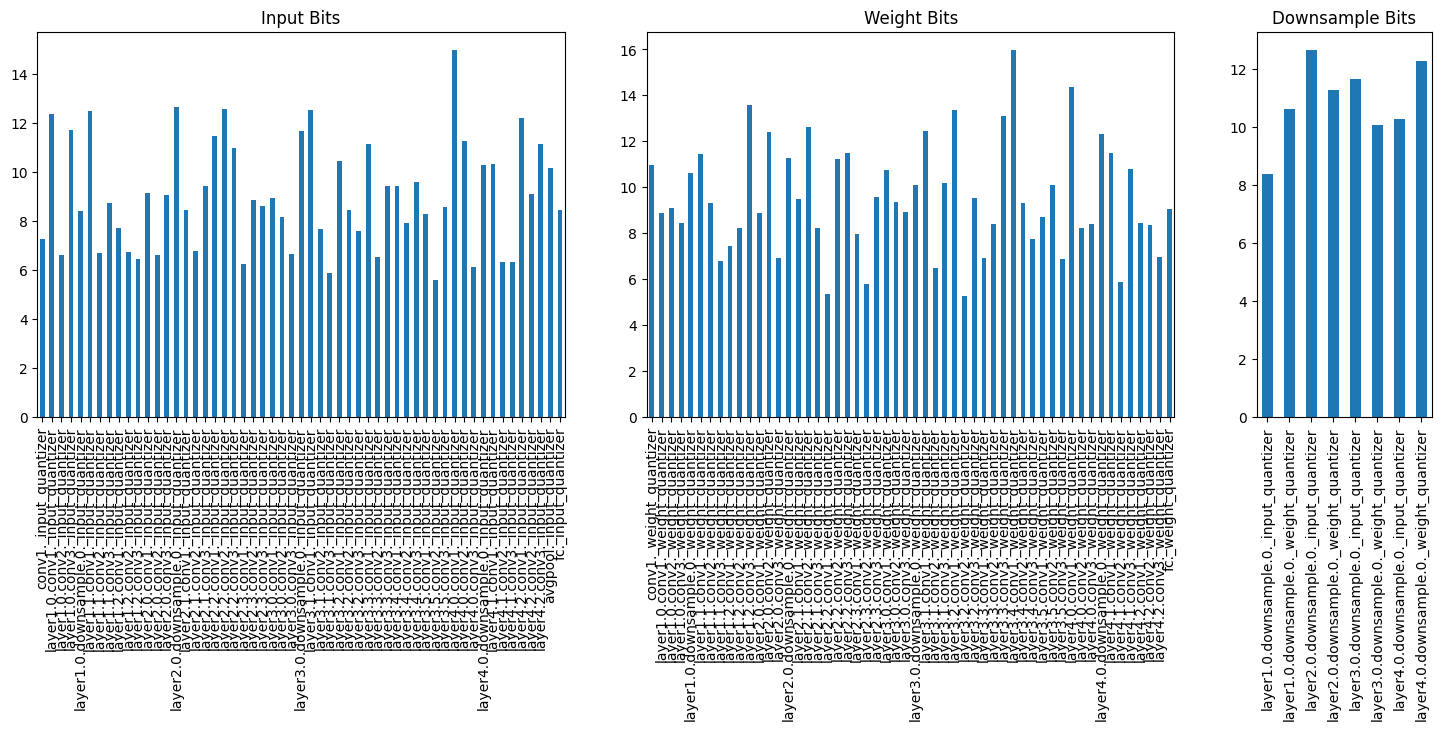

In [70]:
#df_inputs = df_means.loc[:, df_means.columns.str.contains('input')]
import matplotlib.pyplot as plt

df_inputs = df_means.filter(like='input')
df_weights = df_means.filter(like='weight')
df_downsample = df_means.filter(like='downsample')

f, axes = plt.subplots(nrows=1, ncols=3, gridspec_kw={'width_ratios': [3, 3, 1]})
f.set_figheight(5)
f.set_figwidth(18)
df_inputs.plot(kind='bar', ax=axes[0])
axes[0].set_title("Input Bits")

df_weights.plot(kind='bar', ax=axes[1])
axes[1].set_title("Weight Bits")

df_downsample.plot(kind='bar', ax=axes[2])
axes[2].set_title("Downsample Bits")

f.show()
